## BaarleNet [Part 5 - 2x2 tuning]

Semi-fresh start here as I get really going on part 3!

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os

In [2]:
# # Set random seed for reproducibility
# random_seed=25
# torch.manual_seed(random_seed)
# np.random.seed(random_seed)

In [54]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

def get_relu_joint(weight_1, weight_2, bias, extent=1):
    if np.abs(weight_2) < 1e-8: 
        x_intercept = -bias / weight_1
        return [[x_intercept, -extent], [x_intercept, extent]] if -extent <= x_intercept <= extent else []
    elif np.abs(weight_1) < 1e-8:
        y_intercept = -bias / weight_2
        return [[-extent, y_intercept], [extent, y_intercept]] if -extent <= y_intercept <= extent else []
    else:
        points = []
        for x in [-extent, extent]:
            y = (-x * weight_1 - bias) / weight_2
            if -extent <= y <= extent: points.append([x, y])
        for y in [-extent, extent]:
            x = (-y * weight_2 - bias) / weight_1
            if -extent <= x <= extent: points.append([x, y])
        unique_points = []
        for p in points:
            is_duplicate = False
            for existing in unique_points:
                if abs(p[0] - existing[0]) < 1e-8 and abs(p[1] - existing[1]) < 1e-8:
                    is_duplicate = True
                    break
            if not is_duplicate:
                unique_points.append(p)
        return unique_points

def viz_map_with_predictions(ax, map, X, y):
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    
    X_denorm=denorm(X[:1000,:])
    # plt.scatter(X_denorm[:,0], X_denorm[:,1], c=y[:1000], s=2, alpha=0.8)
    labels=y[:1000]
    y_hat=torch.argmax(model(torch.tensor(X[:1000,:]).float()).detach(),1).numpy()
    tp_mask=np.logical_and(labels==1, y_hat==1)
    fp_mask=np.logical_and(labels==0, y_hat==1)
    fn_mask=np.logical_and(labels==1, y_hat==0)
    tn_mask=np.logical_and(labels==0, y_hat==0)
    ax.scatter(X_denorm[tp_mask,0], X_denorm[tp_mask,1], c='g', s=3, alpha=0.8)
    ax.scatter(X_denorm[fp_mask,0], X_denorm[fp_mask,1], c='r', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[fn_mask,0], X_denorm[fn_mask,1], c='orange', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[tn_mask,0], X_denorm[tn_mask,1], c='purple', marker='o', s=5, alpha=0.8)

In [4]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en.svg.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<10
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

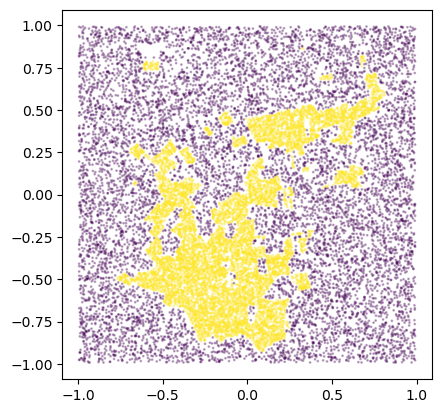

In [5]:
plt.scatter(X[:,0], X[:,1], c=y, s=1, alpha=0.3); plt.axis('square');

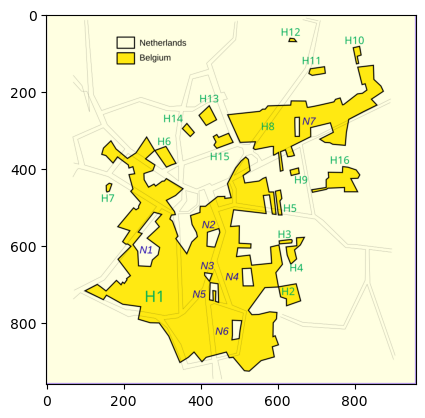

In [6]:
plt.imshow(map)

In [33]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [34]:
# class BaarleNetNoRelu(nn.Module):
#     def __init__(self, hidden_layers=[64]):
#         super(BaarleNet, self).__init__()
#         layers = [nn.Linear(2, hidden_layers[0])] #, nn.ReLU()]
#         for i in range(len(hidden_layers)-1):
#             layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
#             # layers.append(nn.ReLU())
#         layers.append(nn.Linear(hidden_layers[-1], 2))
#         self.layers=layers
#         self.model = nn.Sequential(*layers)
    
#     def forward(self, x):
#         return self.model(x)

In [35]:
## With LayerNorm!

# class BaarleNet(nn.Module):
#     def __init__(self, hidden_layers=[64]):
#         super(BaarleNet, self).__init__()
#         layers = [nn.Linear(2, hidden_layers[0]), nn.LayerNorm(hidden_layers[0]), nn.ReLU()]
        
#         for i in range(len(hidden_layers)-1):
#             layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
#             layers.append(nn.LayerNorm(hidden_layers[i+1]))
#             layers.append(nn.ReLU())
        
#         layers.append(nn.Linear(hidden_layers[-1], 2))
#         self.layers = layers
#         self.model = nn.Sequential(*layers)
    
#     def forward(self, x):
#         return self.model(x)

In [36]:
save_dir='may_20_2'
os.makedirs(save_dir, exist_ok=True)

In [37]:
X.shape

(20000, 2)

- BaarleNet([16, 16, 16, 16]), num_epochs = 10000, batch, Accuracy: 0.9546
- BaarleNet([16, 16, 16, 16]), num_epochs = 10000, stochastic, Accuracy: 0.8749
- BaarleNet([64, 64, 64, 64]), num_epochs = 10000, batch, Accuracy: 0.9810 <- starts to get some nice fine structure

In [179]:
random_seed=0 #Random seed of 3 makes for a nice "fold down the edges" deal, wait that's for 2x2
torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([2])
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005

num_epochs = 2500
for epoch in range(num_epochs):
    # Batch
    # outputs = model(X_tensor)
    # loss = criterion(outputs, y_tensor)

    #Stochastic
    outputs = model(torch.tensor(X[epoch%len(y)]).float())
    loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

    #Worth trying minibatch?
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//25) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [100/2500], Loss: 0.5325, Accuracy: 0.5612
Epoch [200/2500], Loss: 0.9767, Accuracy: 0.6351
Epoch [300/2500], Loss: 0.7994, Accuracy: 0.5792
Epoch [400/2500], Loss: 0.7757, Accuracy: 0.5953
Epoch [500/2500], Loss: 0.4874, Accuracy: 0.6240
Epoch [600/2500], Loss: 0.7564, Accuracy: 0.6510
Epoch [700/2500], Loss: 0.5063, Accuracy: 0.6361
Epoch [800/2500], Loss: 0.4190, Accuracy: 0.6575
Epoch [900/2500], Loss: 0.4173, Accuracy: 0.6580
Epoch [1000/2500], Loss: 0.0802, Accuracy: 0.6641
Epoch [1100/2500], Loss: 0.0780, Accuracy: 0.6875
Epoch [1200/2500], Loss: 1.0805, Accuracy: 0.6643
Epoch [1300/2500], Loss: 1.0410, Accuracy: 0.6748
Epoch [1400/2500], Loss: 0.4624, Accuracy: 0.6644
Epoch [1500/2500], Loss: 0.4298, Accuracy: 0.6960
Epoch [1600/2500], Loss: 1.1263, Accuracy: 0.7050
Epoch [1700/2500], Loss: 0.1041, Accuracy: 0.6900
Epoch [1800/2500], Loss: 0.5115, Accuracy: 0.6953
Epoch [1900/2500], Loss: 0.8895, Accuracy: 0.6741
Epoch [2000/2500], Loss: 0.9234, Accuracy: 0.6809
Epoch [21

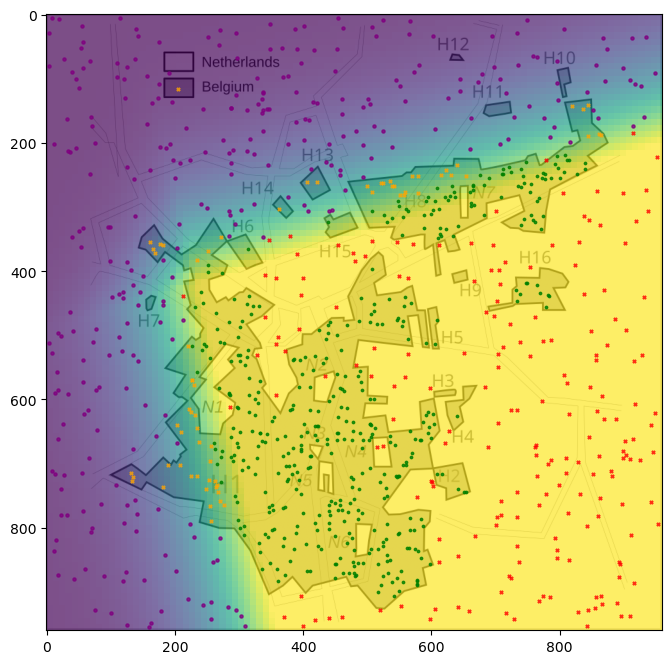

In [180]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)
viz_map_with_predictions(ax, map, X, y)

- Ok ok ok ok ok ok ok ok ok ok ok ok yeah, how do I want to visualize what's happening here? 
- Oh wait, I'm potentially missing a step of not having ReLus...ok yeah that's straigthforward
- Ok ok ok so I'll need to noodle a bit here to land on the viz technique I want here
- I definitely want it to be really clear what the ReLu is doing!
- "Why does it make sense to kink our planes" lol
- I think that I want to try some kinda 3d plane-ish explanation first, and then fall back to the affine 2 transformation approach
- Why our planes need kinks in them...
- Hmm well when we get to the ReLu, I think the interesting framing will be something like -> can you model "fold up" all the belgium regions while folding down all the netherlands regions...
- Hmm yeah composing of planes vs what exactly...
- Ok not totally sure how I want to handle this yet -> it's like clearer if the final layers decision boundarys are horizontal...how "not horizontal" are they right now I wonder? Let me poke at this and see what I can figure out.
- Hmm there's no activation function in the second layer - does that help me at all?

In [181]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

In [182]:
h1 = model.model[:2](torch.tensor(probe).float())
h1 = h1.detach().numpy().reshape(100,100,2)

# First neuron (output index 0)
j1 = get_relu_joint(model.model[0].weight[0,0].item(), model.model[0].weight[0,1].item(), model.model[0].bias[0].item(), extent=1)
j1 = denorm(np.array(j1)) if j1 else []

# Second neuron (output index 1)  
j2 = get_relu_joint(model.model[0].weight[1,0].item(), model.model[0].weight[1,1].item(), model.model[0].bias[1].item(), extent=1)
j2 = denorm(np.array(j2)) if j2 else []

In [183]:
j1

array([[  0.        , 490.73978683],
       [960.        , 198.64369895]])

In [184]:
j2

array([[355.89884725, 960.        ],
       [137.11312068,   0.        ]])

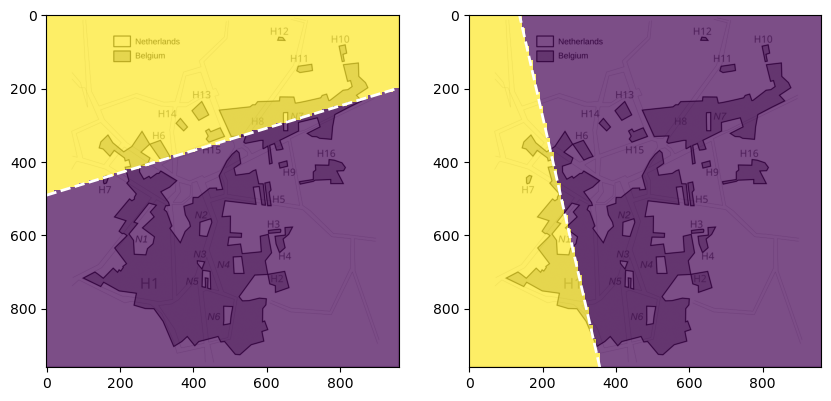

In [185]:
fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h1[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    if i==0: ax.plot([j1[0][0], j1[1][0]], [j1[0][1], j1[1][1]], '--', color='#FFFFFF', linewidth=2)
    if i==1: ax.plot([j2[0][0], j2[1][0]], [j2[0][1], j2[1][1]], '--', color='#FFFFFF', linewidth=2)

- Ok, that's pretty cool
- Now, how to show and think about composition.
- Stacking scaled ReLu planes lets go!!!

In [191]:
h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

In [192]:
h2.shape

(100, 100, 2)

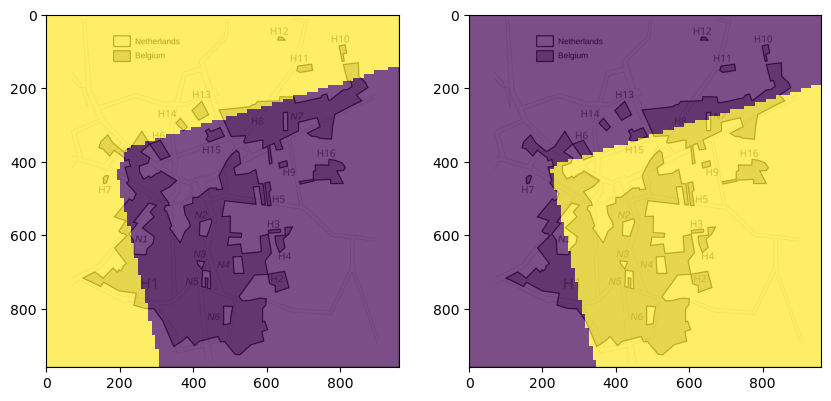

In [193]:
fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')

---

## 2 hidden layers - how do figure out where all the ReLu joints are?

In [285]:
# for random_seed in range(10, 100): 
#     torch.manual_seed(random_seed)  

#     X_tensor = torch.FloatTensor(X)
#     y_tensor = torch.tensor(y)
    
#     # Initialize model and optimizer
#     model = BaarleNet([2,2])
#     criterion = nn.CrossEntropyLoss()
#     # optimizer = optim.SGD(model.parameters(), lr=0.25)
#     optimizer = optim.Adam(model.parameters(), lr=0.005) #0.005
    
#     num_epochs = 5000
#     for epoch in range(num_epochs):
#         # Batch
#         # outputs = model(X_tensor)
#         # loss = criterion(outputs, y_tensor)
    
#         #Stochastic
#         outputs = model(torch.tensor(X[epoch%len(y)]).float())
#         loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 
    
#         #Worth trying minibatch?
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
    
#         # if epoch==307: break #Stop early here so weights don't get updated before we poke around
        
#         optimizer.step()

#     outputs_batch = model(X_tensor)
#     accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
#     print(f'Random Seed = {random_seed}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

Random Seed = 10, Loss: 0.4834, Accuracy: 0.6533
Random Seed = 11, Loss: 0.3959, Accuracy: 0.7792
Random Seed = 12, Loss: 0.5230, Accuracy: 0.6317
Random Seed = 13, Loss: 0.5227, Accuracy: 0.6306
Random Seed = 14, Loss: 0.3154, Accuracy: 0.7486
Random Seed = 15, Loss: 0.2956, Accuracy: 0.7678
Random Seed = 16, Loss: 0.6553, Accuracy: 0.5000
Random Seed = 17, Loss: 0.6553, Accuracy: 0.5000
Random Seed = 18, Loss: 0.3765, Accuracy: 0.7835
Random Seed = 19, Loss: 0.2842, Accuracy: 0.7836
Random Seed = 20, Loss: 0.2910, Accuracy: 0.7681
Random Seed = 21, Loss: 0.2831, Accuracy: 0.6548
Random Seed = 22, Loss: 0.2221, Accuracy: 0.7286
Random Seed = 23, Loss: 0.4865, Accuracy: 0.6528
Random Seed = 24, Loss: 0.6553, Accuracy: 0.5000
Random Seed = 25, Loss: 0.6553, Accuracy: 0.5000
Random Seed = 26, Loss: 0.3100, Accuracy: 0.7783
Random Seed = 27, Loss: 0.3155, Accuracy: 0.7677
Random Seed = 28, Loss: 0.4686, Accuracy: 0.6042
Random Seed = 29, Loss: 0.4208, Accuracy: 0.7835
Random Seed = 30, Lo

In [286]:
#5 is the first one that looks kinda interesting, 8 is a little more interesting, 11 is kinda cool.
random_seed=96
# random_seed=18 
# random_seed=19
# random_seed=26
# random_seed=32
# random_seed=40
# random_seed=48
# random_seed=57
# random_seed=71
# random_seed=78
torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([2,2])
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.005) #0.005

num_epochs = 5000
for epoch in range(num_epochs):
    # Batch
    # outputs = model(X_tensor)
    # loss = criterion(outputs, y_tensor)

    #Stochastic
    outputs = model(torch.tensor(X[epoch%len(y)]).float())
    loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

    #Worth trying minibatch?
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//10) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [500/5000], Loss: 0.1771, Accuracy: 0.6736
Epoch [1000/5000], Loss: 0.1818, Accuracy: 0.7300
Epoch [1500/5000], Loss: 0.2919, Accuracy: 0.7722
Epoch [2000/5000], Loss: 0.2744, Accuracy: 0.8181
Epoch [2500/5000], Loss: 0.1922, Accuracy: 0.7921
Epoch [3000/5000], Loss: 0.2014, Accuracy: 0.8060
Epoch [3500/5000], Loss: 1.5443, Accuracy: 0.8273
Epoch [4000/5000], Loss: 1.3692, Accuracy: 0.8117
Epoch [4500/5000], Loss: 0.6923, Accuracy: 0.8420
Epoch [5000/5000], Loss: 0.3603, Accuracy: 0.8273


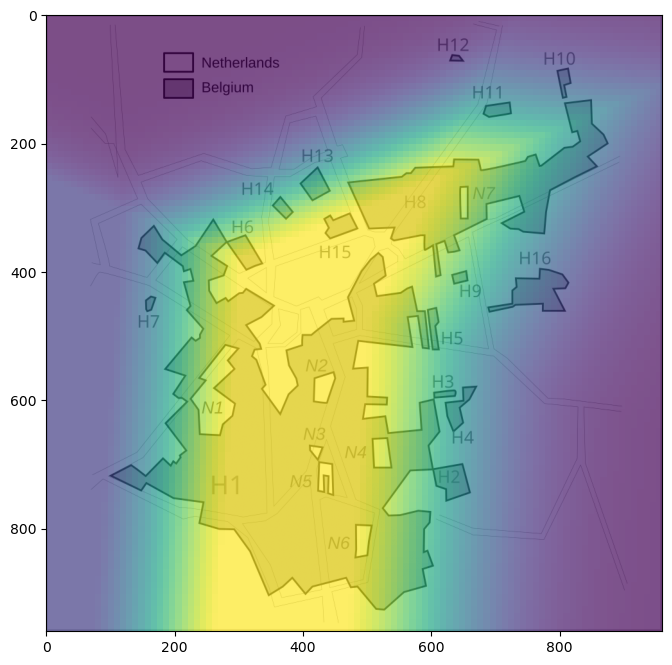

In [287]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)

probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)
probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))

ax.imshow(map.mean(2), cmap='gray')
ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
          # np.flipud(probe_logits[:,1]), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')

In [288]:
h1 = model.model[:2](torch.tensor(probe).float())
h1 = h1.detach().numpy().reshape(100,100,2)

# First neuron (output index 0)
j1 = get_relu_joint(model.model[0].weight[0,0].item(), model.model[0].weight[0,1].item(), model.model[0].bias[0].item(), extent=1)
j1 = denorm(np.array(j1)) if j1 else []

# Second neuron (output index 1)  
j2 = get_relu_joint(model.model[0].weight[1,0].item(), model.model[0].weight[1,1].item(), model.model[0].bias[1].item(), extent=1)
j2 = denorm(np.array(j2)) if j2 else []

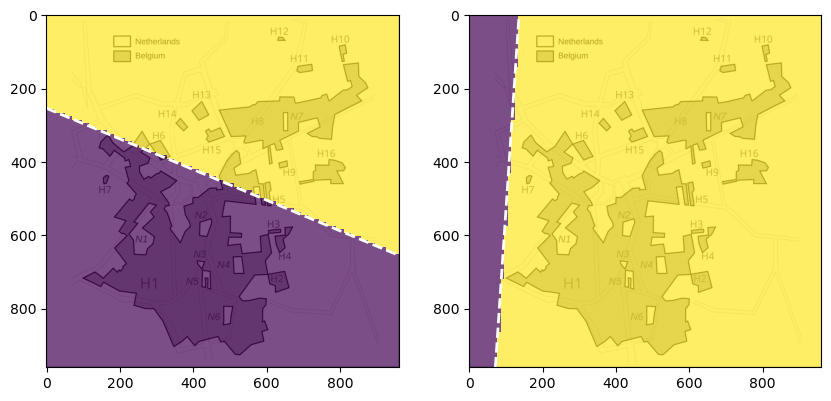

In [289]:
fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h1[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    if i==0: ax.plot([j1[0][0], j1[1][0]], [j1[0][1], j1[1][1]], '--', color='#FFFFFF', linewidth=2)
    if i==1: ax.plot([j2[0][0], j2[1][0]], [j2[0][1], j2[1][1]], '--', color='#FFFFFF', linewidth=2)

In [290]:
h2 = model.model[:4](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

# First neuron (output index 0)
# j1 = get_relu_joint(model.model[0].weight[0,0].item(), model.model[0].weight[0,1].item(), model.model[0].bias[0].item(), extent=1)
# j1 = denorm(np.array(j1)) if j1 else []

# # Second neuron (output index 1)  
# j2 = get_relu_joint(model.model[0].weight[1,0].item(), model.model[0].weight[1,1].item(), model.model[0].bias[1].item(), extent=1)
# j2 = denorm(np.array(j2)) if j2 else []

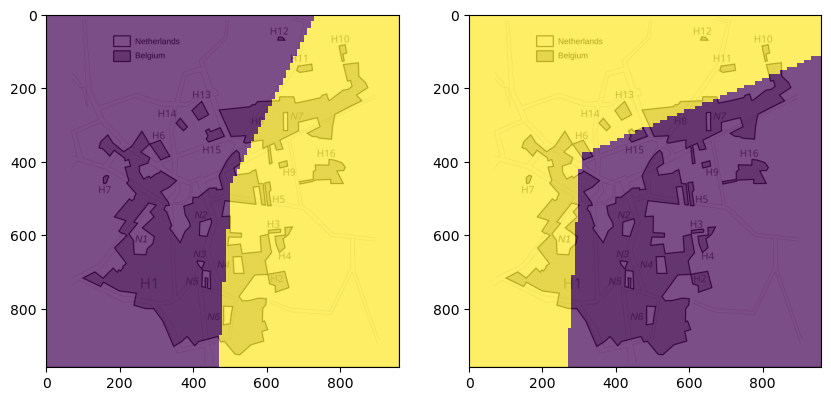

In [291]:
fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    # if i==0: ax.plot([j1[0][0], j1[1][0]], [j1[0][1], j1[1][1]], '--', color='#FFFFFF', linewidth=2)
    # if i==1: ax.plot([j2[0][0], j2[1][0]], [j2[0][1], j2[1][1]], '--', color='#FFFFFF', linewidth=2)

Ok, so 96 is nice - definitely keep to understand what's happening geometrically- it still feels like something i could do with a single hidden layer with 4 hidden units? let me get some Relu boundaries on there next!

In [211]:
model.model

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=2, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2, out_features=2, bias=True)
)

---

In [186]:
h1.shape

(100, 100, 2)

Ok, now what happens?

In [189]:
model.model[2].weight

Parameter containing:
tensor([[ 1.6995,  2.1654],
        [-1.7763, -1.4177]], requires_grad=True)

In [188]:
model.model

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=2, bias=True)
)

- Hmm is there some angle here where we shift/rotate the planes multiple times -> that would make the no relu case really clear
- Hmm like we're transforming a plane in 3d space twice? Hmm need to think about that. That would be pretty cool if it worked like that, but I'm not sure if it does. 

- Multiply the height value (and only the height value) of the first plane or relu plane by 1.6995 and add the second plane multiplied by 2.1654, add the results together
- What does it look like gometrically to mutiply each jointed plane by some number and then add -> hey are we just adding scaled versions of these planes together.
- Hmm there's maybe an interseting "collapsing city points onto a line" angle to it.
- Ok, now adding scale versions of our plane together feels pretty chill. they can be negative too.
- Is that what's happening, or am I missing something
- Ok ok ok, so I feel like we're just stacking scaled relu planes? Is that not what's going on here? Hmm yeah and when you stack em the decision boundaries can stack up in interesting ways? They can be flipped too. 
- I feel like an important/interesting thing here will be way ramping up the number of neurons in the single hidden layer
- Yeah i really feel that I can do the whole thing with just plane height?
- Oh man I geuess we can do training animations too?
- I'm super fuzzy on how this maps to multiple hidden layers

----

In [153]:
np.array(j1)*960

array([[921600.        , 440064.13107285],
       [     0.        , 653016.04919995]])

- Hmm are we mapping Baarle Hertog to 0,1 or -1 -> 1? Might want to do -1 to 1 I think? I think that will be cleaner?
- Ok already doing -1 to 1, dope. 

----

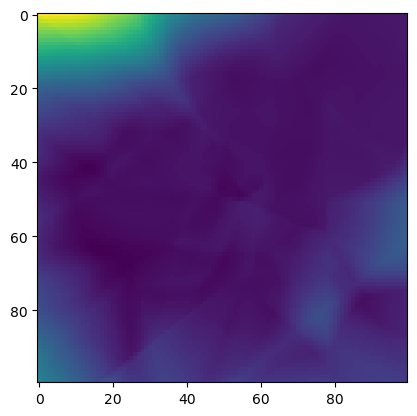

In [13]:
probe=np.zeros((100,100,2))
for i, xx in enumerate(np.linspace(-1, 1, 100)):
    for j, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[i, j]=[xx,yy]
probe=probe.reshape(100**2, -1)

probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
plt.imshow(np.flipud(probe_logits[:,:,0]))

- Need a bit better output viz here I think to really see what's going on
- I do think that I can do some cool visual/animation stuff here with composing ReLUs!

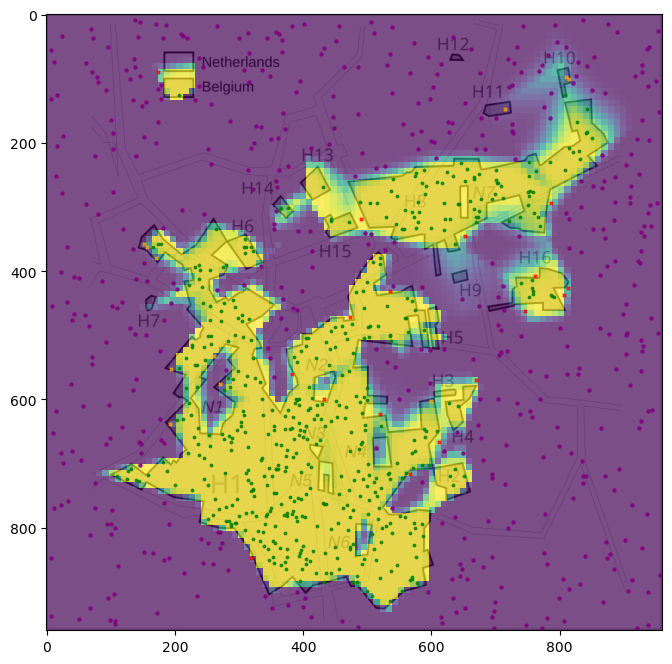

In [14]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)
viz_map_with_predictions(ax, map, X, y)

In [15]:
probe_softmax.shape

torch.Size([10000, 2])

In [16]:
probe_softmax[:,0]>0.5

tensor([True, True, True,  ..., True, True, True])

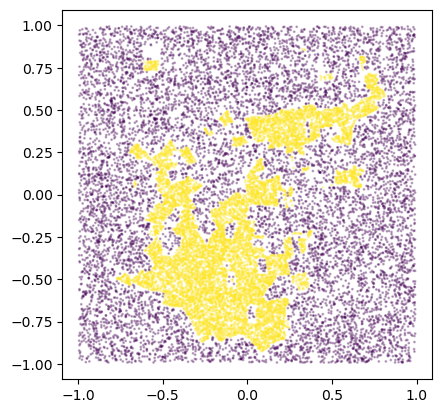

In [17]:
plt.scatter(X[:,0], X[:,1], c=y, s=1, alpha=0.3); plt.axis('square');